<a href="https://colab.research.google.com/github/azydek0/ML-traffic-signs-PL/blob/main/traffic_signs_pl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
import zipfile
import seaborn as sn
import pandas  as pd
# from tensorflow.keras import layers
%matplotlib inline

In [3]:
# Upload *.json file to connect with kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arkadiuszydek","key":"60b15749723185ba775ea4cbe675eb67"}'}

In [4]:
#Prepare kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#Download dataset from kaggle
!kaggle datasets download -d kasia12345/polish-traffic-signs-dataset

 89% 73.0M/82.2M [00:02<00:00, 22.9MB/s]
100% 82.2M/82.2M [00:02<00:00, 29.0MB/s]


In [6]:
# Check files
!ls

kaggle.json  polish-traffic-signs-dataset.zip  sample_data


In [8]:
# Unzip dataset
zip_ref = zipfile.ZipFile('polish-traffic-signs-dataset.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [9]:
# Basic configuration
batch_size = 32                 # Size of batches
IMG_SIZE = (180, 180)           # Size of images in px

base_learning_rate = 0.0001     # Learning rate
initial_epochs = 5              # epochs of basic model

fine_tune_at = 100              # no. nontraining laeyers during tuning
fine_tune_epochs = 5            # epoch of tuning model


In [10]:
# Prepare train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './files/train',
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=batch_size)

Found 16746 files belonging to 92 classes.


In [11]:
# Prepare validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './files/test',
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=batch_size)

Found 4298 files belonging to 92 classes.


In [12]:
# Prepare testing dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 108
Number of test batches: 27


In [13]:
# Check labels names
class_names = train_ds.class_names
print(class_names)

['A-1', 'A-11', 'A-11a', 'A-12a', 'A-14', 'A-15', 'A-16', 'A-17', 'A-18b', 'A-2', 'A-20', 'A-21', 'A-24', 'A-29', 'A-3', 'A-30', 'A-32', 'A-4', 'A-6a', 'A-6b', 'A-6c', 'A-6d', 'A-6e', 'A-7', 'A-8', 'B-1', 'B-18', 'B-2', 'B-20', 'B-21', 'B-22', 'B-25', 'B-26', 'B-27', 'B-33', 'B-34', 'B-36', 'B-41', 'B-42', 'B-43', 'B-44', 'B-5', 'B-6-B-8-B-9', 'B-8', 'B-9', 'C-10', 'C-12', 'C-13', 'C-13-C-16', 'C-13a', 'C-13a-C-16a', 'C-16', 'C-2', 'C-4', 'C-5', 'C-6', 'C-7', 'C-9', 'D-1', 'D-14', 'D-15', 'D-18', 'D-18b', 'D-2', 'D-21', 'D-23', 'D-23a', 'D-24', 'D-26', 'D-26b', 'D-26c', 'D-27', 'D-28', 'D-29', 'D-3', 'D-40', 'D-41', 'D-42', 'D-43', 'D-4a', 'D-4b', 'D-51', 'D-52', 'D-53', 'D-6', 'D-6b', 'D-7', 'D-8', 'D-9', 'D-tablica', 'G-1a', 'G-3']


In [14]:
# Autoconfigure datasets
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
# Rotating images to better classification
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
# Rescale pixels
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [17]:
# Check batches shapes
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [18]:
# Lock weights update in base model
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(92)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 92)


In [21]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [23]:
# no. trainable variables
len(model.trainable_variables)

2

In [24]:
loss0, accuracy0 = model.evaluate(val_ds)

108/108 [==============================] - 10s 63ms/step - loss: 5.0330 - accuracy: 0.0119


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.08
initial accuracy: 0.01


In [26]:
# Start first fit
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/5
524/524 [==============================] - 44s 77ms/step - loss: 2.7523 - accuracy: 0.3495 - val_loss: 1.8511 - val_accuracy: 0.5440
Epoch 2/5
524/524 [==============================] - 40s 76ms/step - loss: 1.4139 - accuracy: 0.6277 - val_loss: 1.2798 - val_accuracy: 0.6683
Epoch 3/5
524/524 [==============================] - 40s 76ms/step - loss: 1.0250 - accuracy: 0.7122 - val_loss: 1.0101 - val_accuracy: 0.7169
Epoch 4/5
524/524 [==============================] - 40s 76ms/step - loss: 0.8193 - accuracy: 0.7565 - val_loss: 0.8602 - val_accuracy: 0.7481
Epoch 5/5
524/524 [==============================] - 40s 76ms/step - loss: 0.6997 - accuracy: 0.7857 - val_loss: 0.7604 - val_accuracy: 0.7682


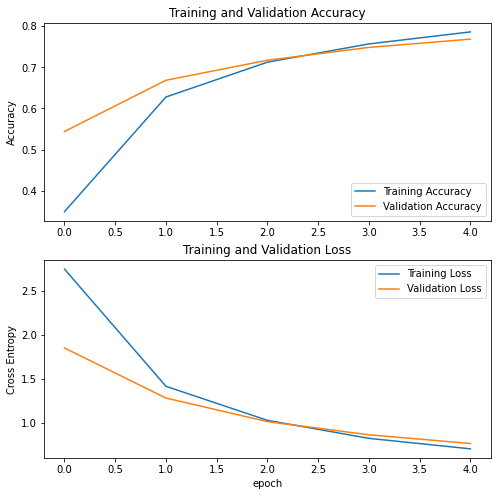

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
# Unlock weights update
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [29]:
# Compile tuning model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [30]:
# no. trainable variables
len(model.trainable_variables)

56

In [31]:
# Start second fit / tuning
# fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/10
524/524 [==============================] - 66s 115ms/step - loss: 0.5111 - accuracy: 0.8241 - val_loss: 0.4444 - val_accuracy: 0.8436
Epoch 6/10
524/524 [==============================] - 59s 113ms/step - loss: 0.3593 - accuracy: 0.8645 - val_loss: 0.3744 - val_accuracy: 0.8605
Epoch 7/10
524/524 [==============================] - 59s 113ms/step - loss: 0.2969 - accuracy: 0.8880 - val_loss: 0.2835 - val_accuracy: 0.9001
Epoch 8/10
524/524 [==============================] - 59s 113ms/step - loss: 0.2486 - accuracy: 0.9052 - val_loss: 0.2636 - val_accuracy: 0.9048
Epoch 9/10
524/524 [==============================] - 59s 113ms/step - loss: 0.2081 - accuracy: 0.9241 - val_loss: 0.2374 - val_accuracy: 0.9231
Epoch 10/10
524/524 [==============================] - 59s 113ms/step - loss: 0.1812 - accuracy: 0.9345 - val_loss: 0.2141 - val_accuracy: 0.9289


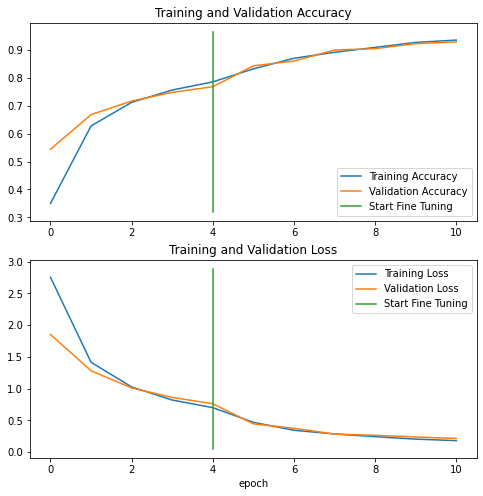

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
# Confusion matrix result
y_pred = []
y_image = list(test_ds.as_numpy_iterator())
y_labels = []
for im in y_image:
    Y_pred = model.predict_on_batch(im[0])
    y_pred.append(np.argmax(Y_pred, axis=1))
    y_labels.append(im[1])
        
y_pred2 = []
y_labels2 = []
for i in y_pred:
    for j in i:
        y_pred2.append(j)

for i in y_labels:
    for j in i:
        y_labels2.append(j)

cm = confusion_matrix(y_labels2,y_pred2)
print(cm.shape)

(88, 88)


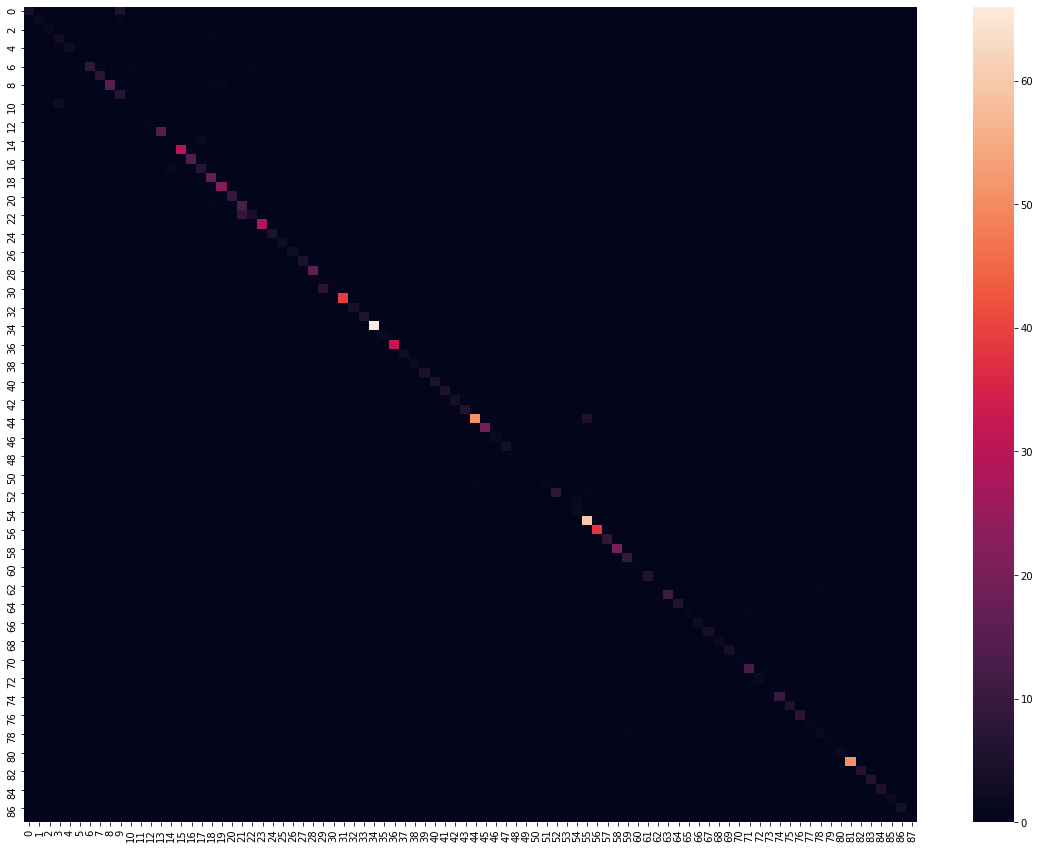

In [34]:
# Visualizing of confusion matrix

df_cm = pd.DataFrame(cm, range(cm.shape[0]),range(cm.shape[1]))
plt.figure(2,figsize = (20,15) )
sn.heatmap(df_cm)# no font
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

27/27 [==============================] - 2s 63ms/step - loss: 0.1956 - accuracy: 0.9306
Test accuracy : 0.9305555820465088


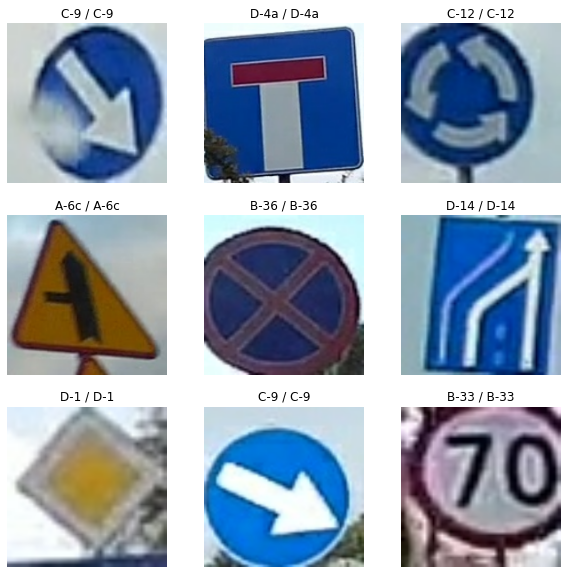

In [36]:
#Retrieve one batch of images to show results
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
classes = np.argmax(predictions, axis = 1)


plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[label_batch[i]] + ' / ' + class_names[classes[i]])
  plt.axis("off")